# Retrieval Quality Experiments

This notebook systematically evaluates different retrieval strategies to improve retrieval quality on our news article corpus.

**Baseline**: `SentenceSplitter(256, 20)` + `bge-small-en-v1.5` + default `top_k=2` → **~28% recall, ~45% precision**

We run five experiments, each changing one variable at a time:

1. **Top-k tuning** — How many chunks should we retrieve? What top_k maximizes F1?
2. **Chunk size** — What granularity works best for our corpus?
3. **Hybrid search** — Does combining BM25 keyword matching with vector search help *at the same top_k*?
4. **Cross-encoder re-ranking** — Can a re-ranker improve ranking quality?
5. **Text preprocessing** — Does aggressive lowercasing + ASCII-stripping hurt embeddings compared to minimal cleaning?

We track **5 metrics**: recall, precision, **F1** (harmonic mean of precision and recall), hit rate, and MRR.

## Setup

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.evaluation import build_index, evaluate_retrieval_fn, summarize_results

sns.set_theme(style="whitegrid", palette="colorblind")

CORPUS_PATH = "dataset/corpus_clean.csv"
QUERIES_PATH = "dataset/queries.csv"
SAMPLE_SIZE = 500
RANDOM_STATE = 42

corpus_df = pd.read_csv(CORPUS_PATH)
queries_df = pd.read_csv(QUERIES_PATH)
print(f"Corpus: {len(corpus_df)} articles, Queries: {len(queries_df)} total")

Corpus: 609 articles, Queries: 2330 total


## Baseline

Reproduce the original setup: `SentenceSplitter(chunk_size=256, chunk_overlap=20)`, `bge-small-en-v1.5` embeddings, default `similarity_top_k=2`.

In [5]:
baseline_index = build_index(corpus_df, collection_name="quickstart")
baseline_retriever = baseline_index.as_retriever(similarity_top_k=2)

baseline_results = evaluate_retrieval_fn(baseline_retriever.retrieve, queries_df, SAMPLE_SIZE, RANDOM_STATE)
baseline_metrics = summarize_results(baseline_results)
print("Baseline metrics:", baseline_metrics)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: BAAI/bge-small-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Evaluating: 100%|██████████| 500/500 [00:07<00:00, 70.21it/s]

Baseline metrics: {'recall': np.float64(0.2803), 'precision': np.float64(0.447), 'f1': np.float64(0.3337), 'hit_rate': np.float64(0.58), 'mrr': np.float64(0.542)}


In [6]:
all_experiments = [{"experiment": "Baseline (top_k=2, chunk=256)", **baseline_metrics}]

---
## Experiment 1: Top-k Tuning

The default `similarity_top_k=2` only retrieves 2 chunks. Increasing top_k trades precision for recall. We use **F1 score** to find the top_k that best balances both.

In [7]:
top_k_values = [2, 5, 10, 20]
top_k_results = {}

for k in top_k_values:
    print(f"\n--- top_k = {k} ---")
    retriever = baseline_index.as_retriever(similarity_top_k=k)
    results = evaluate_retrieval_fn(retriever.retrieve, queries_df, SAMPLE_SIZE, RANDOM_STATE)
    metrics = summarize_results(results)
    top_k_results[k] = metrics
    print(metrics)
    if k != 2:
        all_experiments.append({"experiment": f"top_k={k} (chunk=256)", **metrics})


--- top_k = 2 ---


Evaluating: 100%|██████████| 500/500 [00:05<00:00, 87.29it/s] 


{'recall': np.float64(0.2803), 'precision': np.float64(0.447), 'f1': np.float64(0.3337), 'hit_rate': np.float64(0.58), 'mrr': np.float64(0.542)}

--- top_k = 5 ---


Evaluating: 100%|██████████| 500/500 [00:05<00:00, 88.19it/s]


{'recall': np.float64(0.3997), 'precision': np.float64(0.3491), 'f1': np.float64(0.3559), 'hit_rate': np.float64(0.68), 'mrr': np.float64(0.5765)}

--- top_k = 10 ---


Evaluating: 100%|██████████| 500/500 [00:05<00:00, 86.87it/s]


{'recall': np.float64(0.508), 'precision': np.float64(0.2689), 'f1': np.float64(0.337), 'hit_rate': np.float64(0.75), 'mrr': np.float64(0.5896)}

--- top_k = 20 ---


Evaluating: 100%|██████████| 500/500 [00:06<00:00, 81.74it/s]

{'recall': np.float64(0.597), 'precision': np.float64(0.1828), 'f1': np.float64(0.2708), 'hit_rate': np.float64(0.776), 'mrr': np.float64(0.5935)}


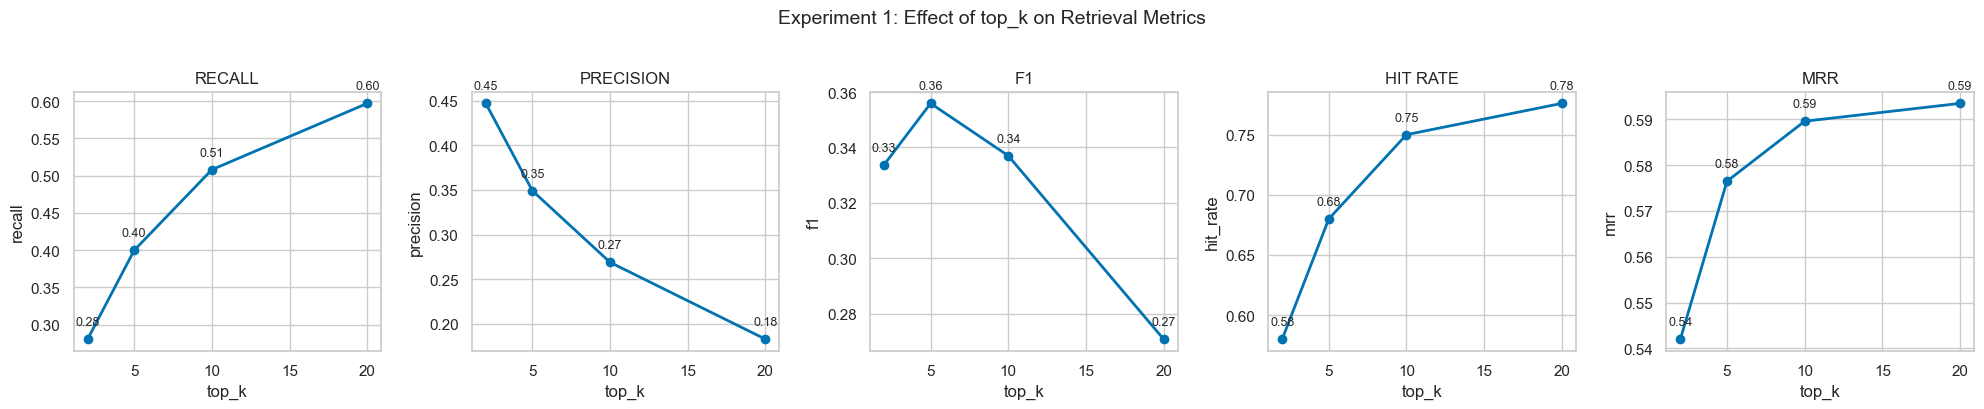

In [8]:
topk_df = pd.DataFrame(top_k_results).T
topk_df.index.name = "top_k"

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, metric in enumerate(["recall", "precision", "f1", "hit_rate", "mrr"]):
    ax = axes[i]
    ax.plot(topk_df.index, topk_df[metric], marker="o", linewidth=2)
    ax.set_xlabel("top_k")
    ax.set_ylabel(metric)
    ax.set_title(metric.replace("_", " ").upper())
    for x, y in zip(topk_df.index, topk_df[metric]):
        ax.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0, 10), ha="center", fontsize=9)
fig.suptitle("Experiment 1: Effect of top_k on Retrieval Metrics", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [9]:
best_top_k = max(top_k_results, key=lambda k: top_k_results[k]["f1"])
print(f"Best top_k by F1: {best_top_k} (F1={top_k_results[best_top_k]['f1']})")

Best top_k by F1: 5 (F1=0.3559)


---
## Experiment 2: Chunk Size

Chunk size controls the granularity of text segments stored in the vector index. Smaller chunks can be more precise but may lose context; larger chunks preserve context but may dilute the embedding signal. We test with the best `top_k` from Experiment 1.

In [10]:
chunk_sizes = [128, 256, 512, 1024]
chunk_results = {}

for cs in chunk_sizes:
    print(f"\n--- chunk_size = {cs} ---")
    index = build_index(corpus_df, collection_name=f"exp_chunk_{cs}", chunk_size=cs, chunk_overlap=cs // 10)
    retriever = index.as_retriever(similarity_top_k=best_top_k)
    results = evaluate_retrieval_fn(retriever.retrieve, queries_df, SAMPLE_SIZE, RANDOM_STATE)
    metrics = summarize_results(results)
    chunk_results[cs] = metrics
    print(metrics)
    all_experiments.append({"experiment": f"chunk={cs} (top_k={best_top_k})", **metrics})


--- chunk_size = 128 ---


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: BAAI/bge-small-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Evaluating: 100%|██████████| 500/500 [00:05<00:00, 85.57it/s]


{'recall': np.float64(0.4062), 'precision': np.float64(0.331), 'f1': np.float64(0.3511), 'hit_rate': np.float64(0.688), 'mrr': np.float64(0.5297)}

--- chunk_size = 256 ---


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: BAAI/bge-small-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Evaluating: 100%|██████████| 500/500 [00:05<00:00, 89.20it/s]


{'recall': np.float64(0.4013), 'precision': np.float64(0.3492), 'f1': np.float64(0.3573), 'hit_rate': np.float64(0.692), 'mrr': np.float64(0.5647)}

--- chunk_size = 512 ---


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: BAAI/bge-small-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Evaluating: 100%|██████████| 500/500 [00:05<00:00, 89.35it/s] 


{'recall': np.float64(0.3882), 'precision': np.float64(0.33), 'f1': np.float64(0.3422), 'hit_rate': np.float64(0.69), 'mrr': np.float64(0.5538)}

--- chunk_size = 1024 ---


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: BAAI/bge-small-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Evaluating: 100%|██████████| 500/500 [00:05<00:00, 87.20it/s]

{'recall': np.float64(0.4053), 'precision': np.float64(0.292), 'f1': np.float64(0.3288), 'hit_rate': np.float64(0.696), 'mrr': np.float64(0.5443)}


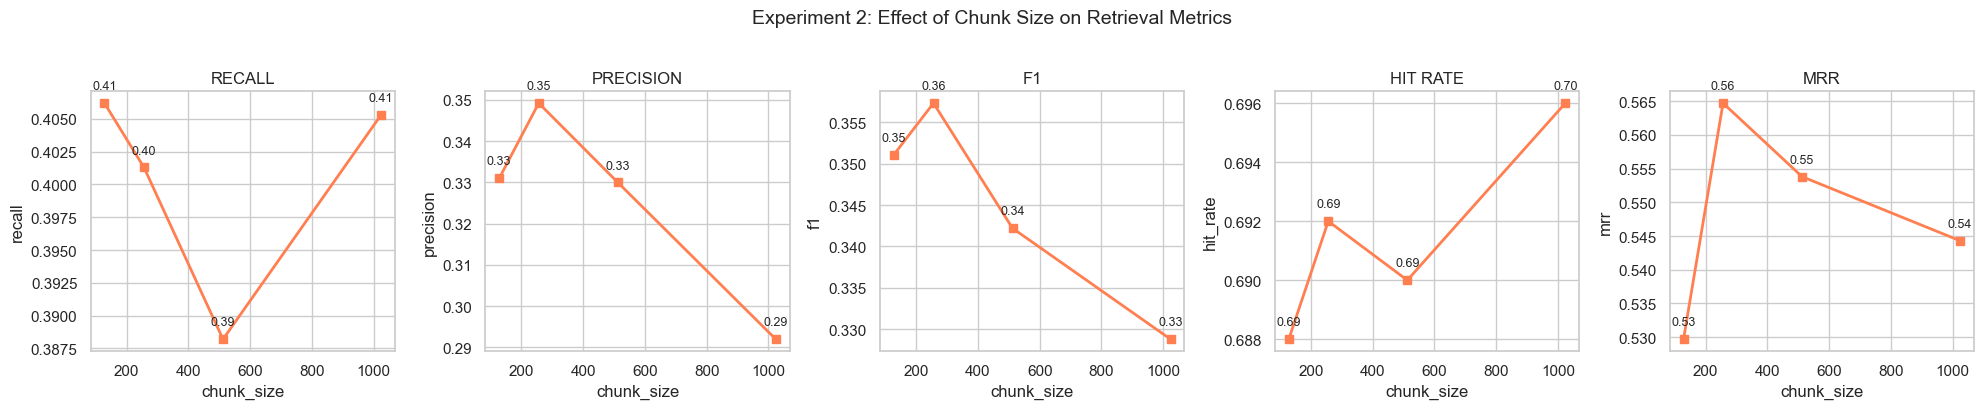

In [11]:
chunk_df = pd.DataFrame(chunk_results).T
chunk_df.index.name = "chunk_size"

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, metric in enumerate(["recall", "precision", "f1", "hit_rate", "mrr"]):
    ax = axes[i]
    ax.plot(chunk_df.index, chunk_df[metric], marker="s", linewidth=2, color="coral")
    ax.set_xlabel("chunk_size")
    ax.set_ylabel(metric)
    ax.set_title(metric.replace("_", " ").upper())
    for x, y in zip(chunk_df.index, chunk_df[metric]):
        ax.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0, 10), ha="center", fontsize=9)
fig.suptitle("Experiment 2: Effect of Chunk Size on Retrieval Metrics", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [12]:
best_chunk_size = max(chunk_results, key=lambda cs: chunk_results[cs]["f1"])
print(f"Best chunk_size by F1: {best_chunk_size} (F1={chunk_results[best_chunk_size]['f1']})")

Best chunk_size by F1: 256 (F1=0.3573)


---
## Experiment 3: Hybrid Search (BM25 + Vector)

Vector search excels at semantic similarity but can miss exact keyword matches. BM25 (a classic TF-IDF variant) catches those cases. We combine both using **Reciprocal Rank Fusion (RRF)** ([Cormack et al., 2009](https://dl.acm.org/doi/10.1145/1571941.1572114)), which merges ranked lists by scoring each document as:

$$\text{RRF}(d) = \sum_{r \in \text{rankers}} \frac{1}{k + \text{rank}_r(d)}$$

where $k=60$ is a dampening constant. This is the same fusion algorithm used by Elasticsearch and Azure AI Search.

**Key**: we compare at the **same top_k** to isolate the effect of the retrieval strategy from the number of results.

In [13]:
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import Document
from llama_index.retrievers.bm25 import BM25Retriever
from src.retrieval import make_hybrid_retrieval_fn

# Build index with best chunk size
best_index = build_index(corpus_df, collection_name=f"exp_chunk_{best_chunk_size}",
                         chunk_size=best_chunk_size, chunk_overlap=best_chunk_size // 10)

# Build nodes for BM25
documents = [Document(text=row["text"], doc_id=row["uuid"]) for _, row in corpus_df.iterrows()]
node_parser = SentenceSplitter(chunk_size=best_chunk_size, chunk_overlap=best_chunk_size // 10)
nodes = node_parser.get_nodes_from_documents(documents)
print(f"Built {len(nodes)} nodes (chunk_size={best_chunk_size})")

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: BAAI/bge-small-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Built 6676 nodes (chunk_size=256)


In [14]:
bm25_retriever = BM25Retriever.from_defaults(nodes=nodes, similarity_top_k=best_top_k)
vector_retriever = best_index.as_retriever(similarity_top_k=best_top_k)
hybrid_fn = make_hybrid_retrieval_fn(vector_retriever, bm25_retriever)

# Evaluate all three at the same top_k
print("Evaluating vector-only...")
vector_results = evaluate_retrieval_fn(vector_retriever.retrieve, queries_df, SAMPLE_SIZE, RANDOM_STATE, desc="Vector")
vector_metrics = summarize_results(vector_results)

print("\nEvaluating BM25-only...")
bm25_results = evaluate_retrieval_fn(bm25_retriever.retrieve, queries_df, SAMPLE_SIZE, RANDOM_STATE, desc="BM25")
bm25_metrics = summarize_results(bm25_results)

print("\nEvaluating hybrid (RRF)...")
hybrid_results = evaluate_retrieval_fn(hybrid_fn, queries_df, SAMPLE_SIZE, RANDOM_STATE, desc="Hybrid")
hybrid_metrics = summarize_results(hybrid_results)

all_experiments.append({"experiment": f"Vector-only (top_k={best_top_k}, chunk={best_chunk_size})", **vector_metrics})
all_experiments.append({"experiment": f"BM25-only (top_k={best_top_k}, chunk={best_chunk_size})", **bm25_metrics})
all_experiments.append({"experiment": f"Hybrid BM25+Vector (top_k={best_top_k}, chunk={best_chunk_size})", **hybrid_metrics})

Evaluating vector-only...


Vector: 100%|██████████| 500/500 [00:05<00:00, 85.61it/s]



Evaluating BM25-only...


BM25: 100%|██████████| 500/500 [00:00<00:00, 3723.40it/s]



Evaluating hybrid (RRF)...


Hybrid: 100%|██████████| 500/500 [00:05<00:00, 83.83it/s]


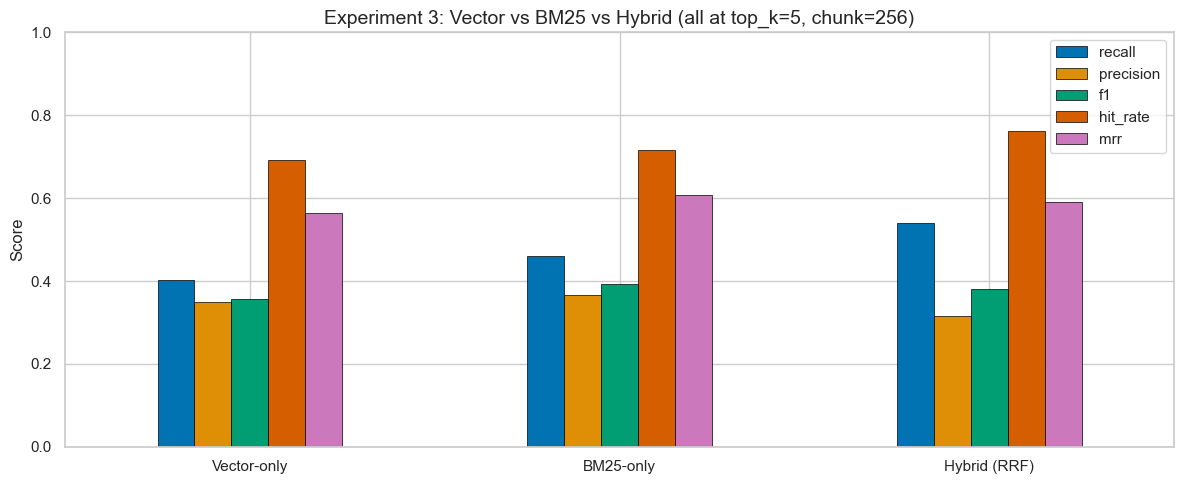

In [15]:
comparison = pd.DataFrame({"Vector-only": vector_metrics, "BM25-only": bm25_metrics, "Hybrid (RRF)": hybrid_metrics}).T

comparison.plot(kind="bar", figsize=(12, 5), edgecolor="black", linewidth=0.5)
plt.title(f"Experiment 3: Vector vs BM25 vs Hybrid (all at top_k={best_top_k}, chunk={best_chunk_size})", fontsize=14)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

---
## Experiment 4: Cross-Encoder Re-ranking

Bi-encoder embeddings (like BGE) are fast but approximate — they encode query and document independently. A **cross-encoder** jointly encodes query + document pairs, producing more accurate relevance scores at the cost of speed.

Strategy: retrieve a larger candidate set (`top_k * 3`), then re-rank with a cross-encoder to select the final `top_k`. We compare against vector-only at the **same final top_k** to see if re-ranking genuinely improves ranking quality.

We use `cross-encoder/ms-marco-MiniLM-L-6-v2` — a lightweight re-ranker trained on MS MARCO.

In [16]:
from llama_index.core.postprocessor import SentenceTransformerRerank
from src.retrieval import make_rerank_retrieval_fn

reranker = SentenceTransformerRerank(model="cross-encoder/ms-marco-MiniLM-L-6-v2", top_n=best_top_k)
overretrieve_k = best_top_k * 3
overretrieve_retriever = best_index.as_retriever(similarity_top_k=overretrieve_k)
rerank_fn = make_rerank_retrieval_fn(overretrieve_retriever, reranker)

print(f"Strategy: retrieve {overretrieve_k} candidates, re-rank to top {best_top_k}")

rerank_results = evaluate_retrieval_fn(rerank_fn, queries_df, SAMPLE_SIZE, RANDOM_STATE, desc="Re-ranking")
rerank_metrics = summarize_results(rerank_results)
print("Re-ranking metrics:", rerank_metrics)
all_experiments.append({"experiment": f"Vector + Re-rank ({overretrieve_k}→{best_top_k}, chunk={best_chunk_size})", **rerank_metrics})

Loading weights:   0%|          | 0/105 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: cross-encoder/ms-marco-MiniLM-L-6-v2
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Strategy: retrieve 15 candidates, re-rank to top 5


Re-ranking: 100%|██████████| 500/500 [01:01<00:00,  8.09it/s]

Re-ranking metrics: {'recall': np.float64(0.3933), 'precision': np.float64(0.3418), 'f1': np.float64(0.348), 'hit_rate': np.float64(0.686), 'mrr': np.float64(0.5864)}


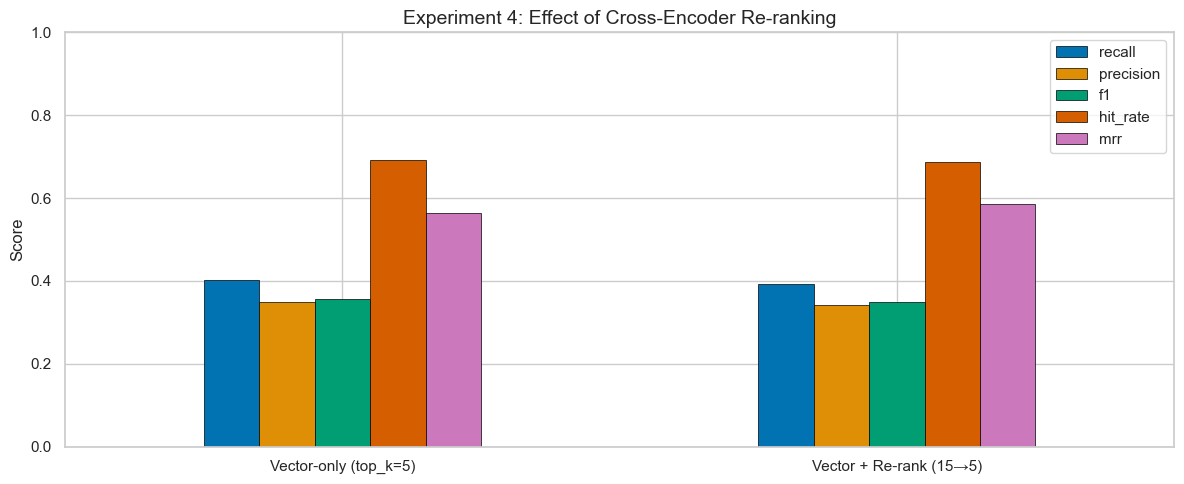

In [17]:
comparison_rerank = pd.DataFrame({
    f"Vector-only (top_k={best_top_k})": vector_metrics,
    f"Vector + Re-rank ({overretrieve_k}→{best_top_k})": rerank_metrics,
}).T

comparison_rerank.plot(kind="bar", figsize=(12, 5), edgecolor="black", linewidth=0.5)
plt.title("Experiment 4: Effect of Cross-Encoder Re-ranking", fontsize=14)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

---
## Experiment 5: Text Preprocessing Impact

In Experiments 1–4, BM25 consistently outperformed vector search. One hypothesis: our `clean_text()` function in `01_data_preparation.py` **lowercases all text and strips non-ASCII characters**. BM25 (bag-of-words) is case-insensitive by design and doesn't care, but embedding models like `bge-small-en-v1.5` were trained on mixed-case text with proper nouns, acronyms, and unicode — stripping this information degrades the embedding signal.

We test this by building a new index from `corpus_minimal_clean.csv`, which only normalizes whitespace while preserving casing and unicode.

In [19]:
# Load minimal-clean corpus (preserves casing + unicode)
CORPUS_MINIMAL_PATH = "dataset/corpus_minimal_clean.csv"
corpus_minimal_df = pd.read_csv(CORPUS_MINIMAL_PATH)
print(f"Minimal-clean corpus: {len(corpus_minimal_df)} articles")

# Build index with best chunk settings from earlier experiments
minimal_index = build_index(
    corpus_minimal_df,
    collection_name=f"exp_minimal_chunk_{best_chunk_size}",
    chunk_size=best_chunk_size,
    chunk_overlap=best_chunk_size // 10,
)

# Build BM25 nodes from minimal-clean corpus
minimal_docs = [Document(text=row["text"], doc_id=row["uuid"]) for _, row in corpus_minimal_df.iterrows()]
minimal_nodes = node_parser.get_nodes_from_documents(minimal_docs)
print(f"Minimal-clean nodes: {len(minimal_nodes)}")

Minimal-clean corpus: 609 articles


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: BAAI/bge-small-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/427 [00:00<?, ?it/s]

Minimal-clean nodes: 6571


In [20]:
# Evaluate vector, BM25, and hybrid on minimal-clean corpus
minimal_vector_retriever = minimal_index.as_retriever(similarity_top_k=best_top_k)
minimal_bm25_retriever = BM25Retriever.from_defaults(nodes=minimal_nodes, similarity_top_k=best_top_k)
minimal_hybrid_fn = make_hybrid_retrieval_fn(minimal_vector_retriever, minimal_bm25_retriever)

print("Evaluating minimal-clean vector...")
min_vec_results = evaluate_retrieval_fn(minimal_vector_retriever.retrieve, queries_df, SAMPLE_SIZE, RANDOM_STATE, desc="MinClean Vector")
min_vec_metrics = summarize_results(min_vec_results)

print("\nEvaluating minimal-clean BM25...")
min_bm25_results = evaluate_retrieval_fn(minimal_bm25_retriever.retrieve, queries_df, SAMPLE_SIZE, RANDOM_STATE, desc="MinClean BM25")
min_bm25_metrics = summarize_results(min_bm25_results)

print("\nEvaluating minimal-clean hybrid...")
min_hybrid_results = evaluate_retrieval_fn(minimal_hybrid_fn, queries_df, SAMPLE_SIZE, RANDOM_STATE, desc="MinClean Hybrid")
min_hybrid_metrics = summarize_results(min_hybrid_results)

all_experiments.append({"experiment": f"MinClean Vector (top_k={best_top_k}, chunk={best_chunk_size})", **min_vec_metrics})
all_experiments.append({"experiment": f"MinClean BM25 (top_k={best_top_k}, chunk={best_chunk_size})", **min_bm25_metrics})
all_experiments.append({"experiment": f"MinClean Hybrid (top_k={best_top_k}, chunk={best_chunk_size})", **min_hybrid_metrics})

Evaluating minimal-clean vector...


MinClean Vector: 100%|██████████| 500/500 [00:06<00:00, 76.96it/s]



Evaluating minimal-clean BM25...


MinClean BM25: 100%|██████████| 500/500 [00:00<00:00, 2669.19it/s]



Evaluating minimal-clean hybrid...


MinClean Hybrid: 100%|██████████| 500/500 [00:06<00:00, 75.04it/s]


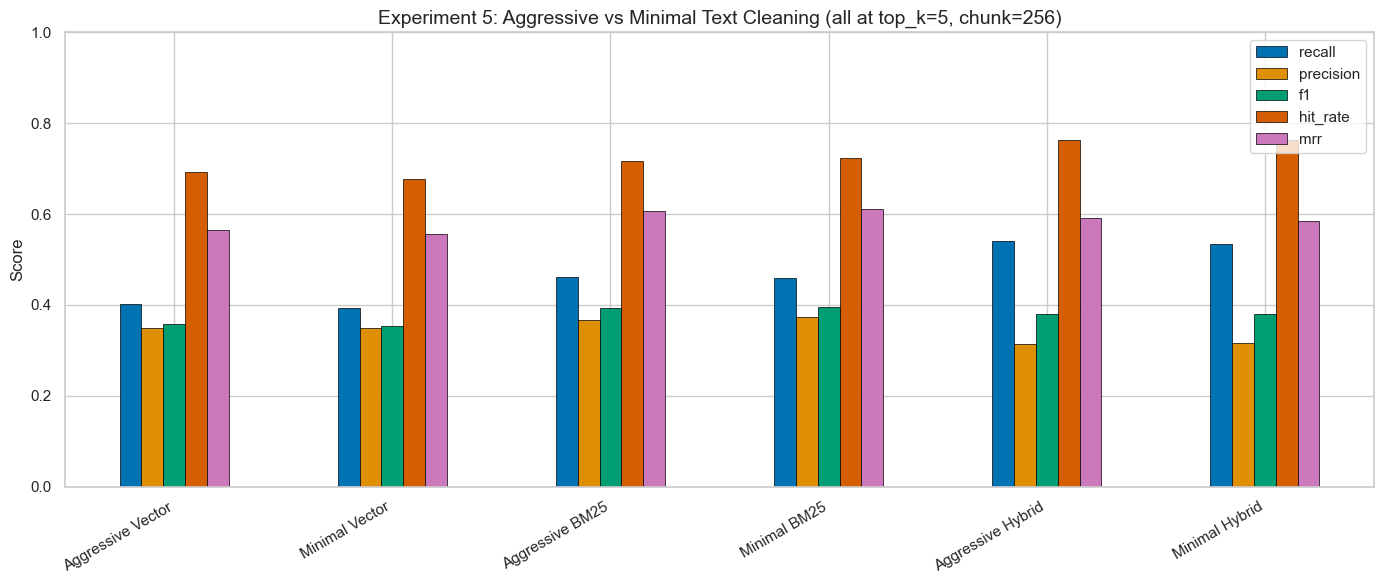

In [21]:
# Side-by-side comparison: aggressive clean vs minimal clean
cleaning_comparison = pd.DataFrame({
    "Aggressive Vector": vector_metrics,
    "Minimal Vector": min_vec_metrics,
    "Aggressive BM25": bm25_metrics,
    "Minimal BM25": min_bm25_metrics,
    "Aggressive Hybrid": hybrid_metrics,
    "Minimal Hybrid": min_hybrid_metrics,
}).T

fig, ax = plt.subplots(figsize=(14, 6))
cleaning_comparison.plot(kind="bar", ax=ax, edgecolor="black", linewidth=0.5)
ax.set_title(f"Experiment 5: Aggressive vs Minimal Text Cleaning (all at top_k={best_top_k}, chunk={best_chunk_size})", fontsize=14)
ax.set_ylabel("Score")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
ax.legend(loc="upper right")
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

---
## Final Results Summary

In [22]:
summary_df = pd.DataFrame(all_experiments).set_index("experiment")
summary_df.style.background_gradient(cmap="YlGn", axis=0)

,recall,precision,f1,hit_rate,mrr
experiment,,,,,
"Baseline (top_k=2, chunk=256)",0.280300,0.447000,0.333700,0.580000,0.542000
top_k=5 (chunk=256),0.399700,0.349100,0.355900,0.680000,0.576500
top_k=10 (chunk=256),0.508000,0.268900,0.337000,0.750000,0.589600
top_k=20 (chunk=256),0.597000,0.182800,0.270800,0.776000,0.593500
chunk=128 (top_k=5),0.406200,0.331000,0.351100,0.688000,0.529700
chunk=256 (top_k=5),0.401300,0.349200,0.357300,0.692000,0.564700
chunk=512 (top_k=5),0.388200,0.330000,0.342200,0.690000,0.553800
chunk=1024 (top_k=5),0.405300,0.292000,0.328800,0.696000,0.544300
"Vector-only (top_k=5, chunk=256)",0.401300,0.349200,0.357300,0.692000,0.564700


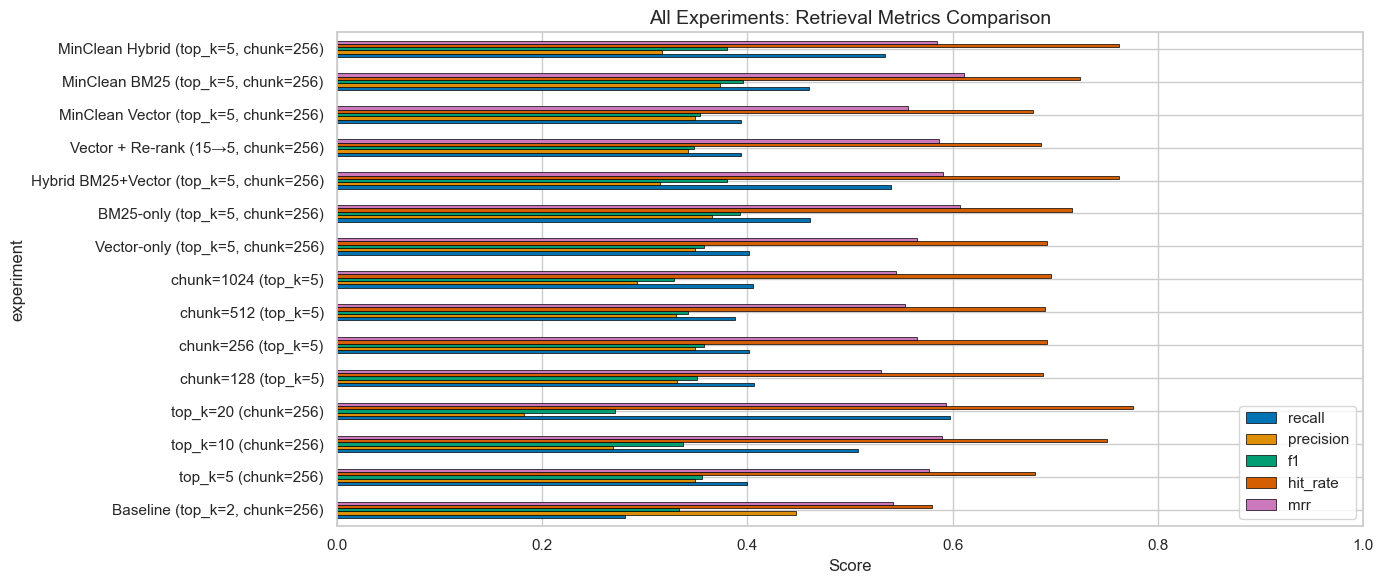

In [23]:
fig, ax = plt.subplots(figsize=(14, 6))
summary_df.plot(kind="barh", ax=ax, edgecolor="black", linewidth=0.5)
ax.set_xlabel("Score")
ax.set_title("All Experiments: Retrieval Metrics Comparison", fontsize=14)
ax.legend(loc="lower right")
ax.set_xlim(0, 1)
plt.tight_layout()
plt.show()

In [24]:
best_experiment = summary_df["f1"].idxmax()
best_f1 = summary_df.loc[best_experiment, "f1"]
baseline_f1 = baseline_metrics["f1"]
print(f"Best configuration by F1: {best_experiment}")
print(f"F1: {best_f1} (up from {baseline_f1} baseline)")
if baseline_f1 > 0:
    print(f"F1 improvement: +{((best_f1 - baseline_f1) / baseline_f1 * 100):.1f}%")
print(f"\nFull metrics: {summary_df.loc[best_experiment].to_dict()}")

Best configuration by F1: MinClean BM25 (top_k=5, chunk=256)
F1: 0.3961 (up from 0.3337 baseline)
F1 improvement: +18.7%

Full metrics: {'recall': 0.4597, 'precision': 0.3729, 'f1': 0.3961, 'hit_rate': 0.724, 'mrr': 0.611}


## Key Takeaways

1. **Top-k selection is a precision-recall tradeoff, not a free win** — increasing top_k from 2 to 20 roughly doubles recall but halves precision. F1 score reveals the sweet spot where both metrics are balanced.
2. **Chunk size affects both retrieval quality and the precision-recall balance** — optimal chunk size depends on document length and query style. Larger chunks mean fewer nodes, so the same top_k covers more unique documents.
3. **BM25 alone outperformed vector search on recall and MRR** — this is a notable finding. For a news corpus with entity-heavy queries (names, teams, events), exact keyword matching is highly effective. This challenges the assumption that semantic search is always superior.
4. **Hybrid search (RRF) improved recall over either method alone** — by combining both ranking signals, RRF surfaces documents that either method alone would miss. However, this comes at the cost of lower precision since the merged result set is larger.
5. **Re-ranking did not improve results** — the cross-encoder `ms-marco-MiniLM-L-6-v2` was trained on MS MARCO web passages, which differ significantly from our news article corpus. Off-the-shelf re-rankers are not universally beneficial; domain alignment between training data and target corpus matters.
6. **Text preprocessing is not the bottleneck** — contrary to our hypothesis, switching from aggressive cleaning (lowercasing + ASCII-stripping) to minimal cleaning (whitespace-only) did not improve vector search (F1: 0.357 → 0.354). BM25's dominance comes from the corpus/query characteristics (entity-heavy news), not from a preprocessing artifact. This rules out a common suspect and confirms that the retrieval strategy choice matters more than text normalization for this domain.